### 1. Multi-Layer Perceptron (MLP) Neural Network

#### 1.1 Exploratory Analysis

In [ ]:
describe = data.describe()
Result = []
for i in range(len(housing["feature_names"])):
    feature = housing["feature_names"][i]
    avg = describe[i][1]
    min = describe[i][3]
    max = describe[i][7]
    Result.append([feature, avg, min, max])
pd.DataFrame(Result, columns=["Feaure", "Avg", "Min", "Max"])

,Feaure,Avg,Min,Max
0,CRIM,3.613524,0.00632,88.9762
1,ZN,11.363636,0.00000,100.0000
2,INDUS,11.136779,0.46000,27.7400
3,CHAS,0.069170,0.00000,1.0000
4,NOX,0.554695,0.38500,0.8710
5,RM,6.284634,3.56100,8.7800
6,AGE,68.574901,2.90000,100.0000
7,DIS,3.795043,1.12960,12.1265
8,RAD,9.549407,1.00000,24.0000
9,TAX,408.237154,187.00000,711.0000


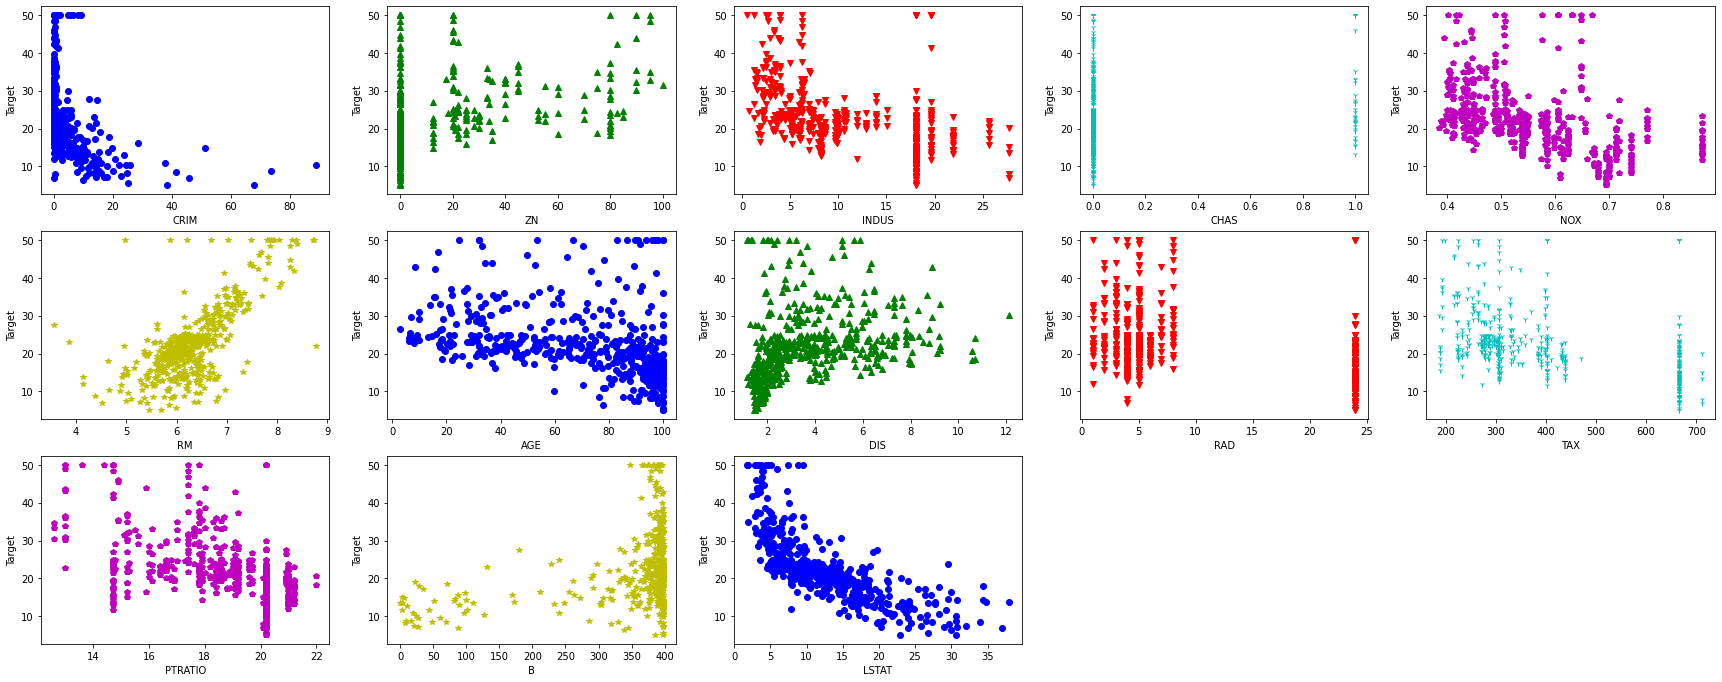

In [ ]:
y = target.values.T[0]
plt.figure(figsize=(30, 20)) 
colors = ['bo', 'g^', 'rv', 'c1', 'mp', 'y*']
for i in range(len(housing["feature_names"])):
    x = data[i]
    plt.subplot(5, 5, i+1)
    plt.plot(x, y, colors[i%6])
    plt.xlabel(housing["feature_names"][i])
    plt.ylabel('Target')
plt.show()

#### 1.2 Data Pre-processing

In [ ]:
# Standardize and Splitting Dataset
for i in range(len(housing["feature_names"])):
  data[i] = (data[i] - data[i].mean()) / data[i].std()

# target = (target - target.mean()) / target.std()

In [ ]:
def train_test_split(data, target, test_size):

    test_size = round(test_size * len(data))

    indices = data.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = data.loc[test_indices]
    test_y = target.loc[test_indices]
    train_df = data.drop(test_indices)
    train_y = target.drop(test_indices)
    
    return train_df, train_y, test_df, test_y

In [ ]:
train_x, train_y, test_x, test_y = train_test_split(data, target, test_size=.2)

In [ ]:
train_x = train_x.values
train_y = train_y.values
test_x = test_x.values
test_y = test_y.values

#### 1.3 We will perform customized forward and backward propagation


In [ ]:
# Define Abstract class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward_propagation(self, input):
        pass

    def backward_propagation(self, output_error, learning_rate):
        pass

In [ ]:
class FCLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size)
        self.bias = np.random.rand(1, output_size)

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(input_data, self.weights) + self.bias
        return self.output

    def update_parameters(self, learning_rate, weights_error, output_error):
         # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * np.sum(output_error, axis=0, keepdims=True)

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.update_parameters(learning_rate, weights_error, output_error)
        return input_error

       

In [ ]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * np.sum(output_error, axis=0, keepdims=True)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
  
def sigmoid_prime(x):
    return np.exp(-x)/(1+np.exp(-x))**2

In [ ]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

In [ ]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

#### 1.4 

In [ ]:
class Model:

    def __init__(self):

        input_size = 13
        output_size = 15
        self.hidden_layer = FCLayer(input_size, output_size)
        self.hidden_layer_activation = ActivationLayer(tanh, tanh_prime)


        input_size = 15
        output_size = 1
        self.output_layer = FCLayer(input_size, output_size)

    def predict(self, test_x, test_y):
        output = self.hidden_layer.forward_propagation(test_x)
        output = self.hidden_layer_activation.forward_propagation(output)
        output = self.output_layer.forward_propagation(output)

        # compute loss (for display purpose only)
        return mse(test_y, output)

    def fit(self, train_x, train_y, learning_rate, epochs, batch_size):

        samples = len(train_x)
        err = 0
        history = []
        for index in range(epochs):
            j = 0
            while j < samples:
                # forward propagation
                output = train_x[j:j+batch_size]
                output = self.hidden_layer.forward_propagation(output)
                output = self.hidden_layer_activation.forward_propagation(output)
                output = self.output_layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += mse(train_y[j:j+batch_size], output)
                # print(err)
                # backward propagation
                error = mse_prime(train_y[j:j+batch_size], output)
                error = self.output_layer.backward_propagation(error, learning_rate)
                error = self.hidden_layer_activation.backward_propagation(error, learning_rate)
                error = self.hidden_layer.backward_propagation(error, learning_rate)

                j += batch_size

            # calculate average error on all samples
            err /= samples
            history.append({
                      'epoch': index,
                      'err': err
                  })
            print('epoch %d/%d   error=%f' % (index+1, epochs, err))
        return history

#### 1.5 Final Accuracy

In [ ]:
model1 = Model()
learning_rate = 0.01
epochs = 100
batch_size = len(train_x)
history_batch = model1.fit(train_x, train_y, learning_rate, epochs, batch_size)

epoch 1/100   error=1.590651
epoch 2/100   error=1.036703
epoch 3/100   error=0.943871
epoch 4/100   error=0.878097
epoch 5/100   error=0.818526
epoch 6/100   error=0.806391
epoch 7/100   error=0.740259
epoch 8/100   error=0.654437
epoch 9/100   error=0.579723
epoch 10/100   error=0.536993
epoch 11/100   error=0.479142
epoch 12/100   error=0.436316
epoch 13/100   error=0.396018
epoch 14/100   error=0.361554
epoch 15/100   error=0.332647
epoch 16/100   error=0.308193
epoch 17/100   error=0.287432
epoch 18/100   error=0.269787
epoch 19/100   error=0.254818
epoch 20/100   error=0.242057
epoch 21/100   error=0.231140
epoch 22/100   error=0.221806
epoch 23/100   error=0.213823
epoch 24/100   error=0.206992
epoch 25/100   error=0.201147
epoch 26/100   error=0.196144
epoch 27/100   error=0.191860
epoch 28/100   error=0.188192
epoch 29/100   error=0.185051
epoch 30/100   error=0.182363
epoch 31/100   error=0.180063
epoch 32/100   error=0.178094
epoch 33/100   error=0.176406
epoch 34/100   erro

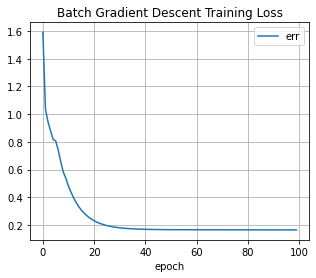

In [ ]:
pd.DataFrame(history_batch).plot(x='epoch', y='err', grid=True, figsize=(5,4), title="Batch Gradient Descent Training Loss")

In [ ]:
model2 = Model()
learning_rate = 0.01
epochs = 100
batch_size = 1
history_stochastic = model2.fit(train_x, train_y, learning_rate, epochs, batch_size)

epoch 1/100   error=48.518274
epoch 2/100   error=44.119052
epoch 3/100   error=32.961852
epoch 4/100   error=30.158407
epoch 5/100   error=27.993241
epoch 6/100   error=26.679613
epoch 7/100   error=25.938700
epoch 8/100   error=25.780777
epoch 9/100   error=28.627335
epoch 10/100   error=26.582708
epoch 11/100   error=25.871044
epoch 12/100   error=28.008824
epoch 13/100   error=26.679504
epoch 14/100   error=24.867567
epoch 15/100   error=23.899762
epoch 16/100   error=25.032948
epoch 17/100   error=24.531398
epoch 18/100   error=24.812599
epoch 19/100   error=23.515251
epoch 20/100   error=23.303704
epoch 21/100   error=23.566262
epoch 22/100   error=22.891944
epoch 23/100   error=21.912697
epoch 24/100   error=22.061131
epoch 25/100   error=20.988484
epoch 26/100   error=20.544452
epoch 27/100   error=23.058159
epoch 28/100   error=21.829141
epoch 29/100   error=20.955759
epoch 30/100   error=22.752055
epoch 31/100   error=25.100364
epoch 32/100   error=23.315932
epoch 33/100   er

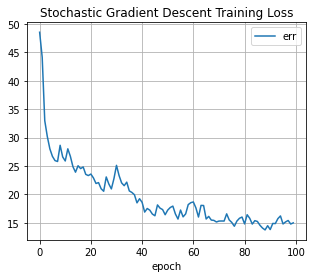

In [ ]:
pd.DataFrame(history_stochastic).plot(x='epoch', y='err', grid=True, figsize=(5,4), title="Stochastic Gradient Descent Training Loss")

In [ ]:
result = model1.predict(test_x, test_y)
print('Batch gradient accuracy on test data: ', result)

Batch gradient accuracy on test data:  65.51439156858717


In [ ]:
result = model2.predict(test_x, test_y)
print('Stochastic gradient accuracy on test data: ', result)

Stochastic gradient accuracy on test data:  28.40851418752494


#### 1.6 Training of MLP on different learning rate

In [ ]:
lr_hist = []
lr = [ 0.5, 0.1, 0.01, 0.001, 0.0001]
for learning_rate in lr:
    model = Model()
    epochs = 100
    batch_size = 1
    history = model.fit(train_x, train_y, learning_rate, epochs, batch_size)
    for d in history:
      d['lr'] = learning_rate
    lr_hist.extend(history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


epoch 1/100   error=nan
epoch 2/100   error=nan
epoch 3/100   error=nan
epoch 4/100   error=nan
epoch 5/100   error=nan
epoch 6/100   error=nan
epoch 7/100   error=nan
epoch 8/100   error=nan
epoch 9/100   error=nan
epoch 10/100   error=nan
epoch 11/100   error=nan
epoch 12/100   error=nan
epoch 13/100   error=nan
epoch 14/100   error=nan
epoch 15/100   error=nan
epoch 16/100   error=nan
epoch 17/100   error=nan
epoch 18/100   error=nan
epoch 19/100   error=nan
epoch 20/100   error=nan
epoch 21/100   error=nan
epoch 22/100   error=nan
epoch 23/100   error=nan
epoch 24/100   error=nan
epoch 25/100   error=nan
epoch 26/100   error=nan
epoch 27/100   error=nan
epoch 28/100   error=nan
epoch 29/100   error=nan
epoch 30/100   error=nan
epoch 31/100   error=nan
epoch 32/100   error=nan
epoch 33/100   error=nan
epoch 34/100   error=nan
epoch 35/100   error=nan
epoch 36/100   error=nan
epoch 37/100   error=nan
epoch 38/100   error=nan
epoch 39/100   error=nan
epoch 40/100   error=nan
epoch 41/

#### 1.7 Plot

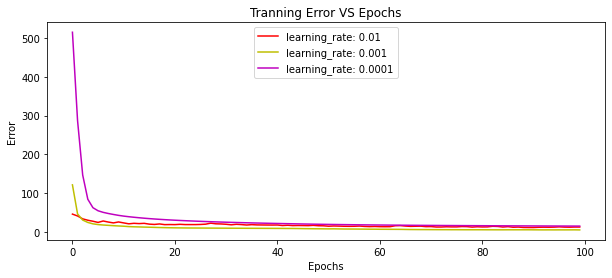

In [ ]:
lr_hist_df = pd.DataFrame(lr_hist)

plt.figure(figsize=(10, 4))

data = lr_hist_df[lr_hist_df['lr']==0.5].values
x_axis = data[:, 0]
y_axis = data[:, 1]
# plt.plot(x_axis, y_axis, 'b-', label='learning_rate: '+str(0.5))

data = lr_hist_df[lr_hist_df['lr']==0.1].values
x_axis = data[:, 0]
y_axis = data[:, 1]
# plt.plot(x_axis, y_axis, 'g-', label='learning_rate: '+str(0.1))

data = lr_hist_df[lr_hist_df['lr']==0.01].values
x_axis = data[:, 0]
y_axis = data[:, 1]
plt.plot(x_axis, y_axis, 'r-', label='learning_rate: '+str(0.01))

data = lr_hist_df[lr_hist_df['lr']==0.001].values
x_axis = data[:, 0]
y_axis = data[:, 1]
plt.plot(x_axis, y_axis, 'y-', label='learning_rate: '+str(0.001))

data = lr_hist_df[lr_hist_df['lr']==0.0001].values
x_axis = data[:, 0]
y_axis = data[:, 1]
plt.plot(x_axis, y_axis, 'm-', label='learning_rate: '+str(0.0001))

plt.title("Tranning Error VS Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.rcParams["figure.figsize"] = [10.50, 7.50]
plt.rcParams["figure.autolayout"] = True
plt.legend(loc='upper center')
plt.show()

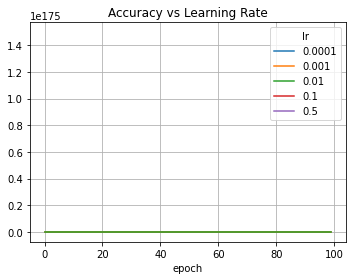

In [ ]:
# Plots Accuracy vs Learning Rate
lr_hist_df.pivot('epoch', values='err', columns='lr').plot(figsize=(5,4), grid=True, title = 'Accuracy vs Learning Rate')

#### Challenges and Observations

For learning rate 0.5 and 0.1, the error rate is increased as number of iterations increased, because of overfitting.

For smaller learning rate which are 0.01, 0.001. 0.0001, the gradient descent converges to a local minima

In [ ]:
# import Fashion MNIST dataset
import keras
from keras.datasets import fashion_mnist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() #load dataset

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
classes, count = np.unique(train_labels, return_counts=True)

#### 2.1 Dataset Exploration

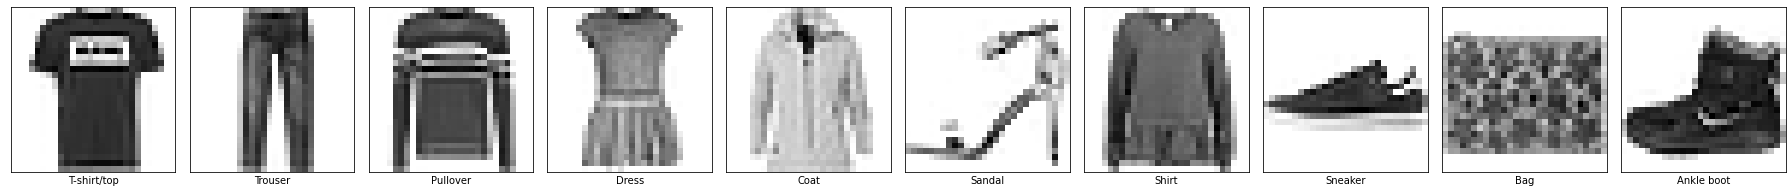

In [ ]:
#Dataset Exploration
plt.figure(figsize=(25,30))
for c in classes:
    plt.subplot(10,10,c+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = train_images[train_labels == c][0]
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[c])
plt.show()


#### 2.2 Distribution of number of images in each fashion class

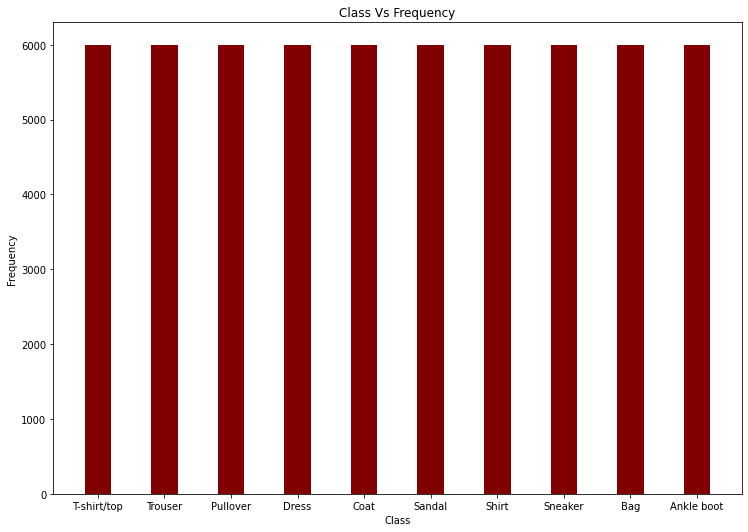

In [ ]:
plt.bar(class_names, count, color ='maroon', width = 0.4)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Vs Frequency")
plt.show()

The Distribution of each class is uniform

#### 2.3 2D convolution function using a kernel size of 3x3

In [ ]:
# Model Structure 
def convolve(X):

    vertical_grad_filter = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]]).flatten()
    horizontal_grad_filter = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]]).flatten()

    X_height, X_width = X.shape
    
    F_height, F_width = (3,3)
    
    #output numpy matrix with height and width
    out = np.zeros((X_height, X_width))

    #iterate over all the pixel of image X
    for i in np.arange(1, X_height-1):
        for j in np.arange(1, X_width-1):
            x = image[i - 1: i + 1 + 1, j - 1: j + 1 + 1]
            flat = x.flatten()
            x = flat * vertical_grad_filter
            sum_x = x.sum()

            y = flat * horizontal_grad_filter
            sum_y = y.sum()

            out[i - 1][j - 1] = np.sqrt(sum_x**2 + sum_y**2)
    return out

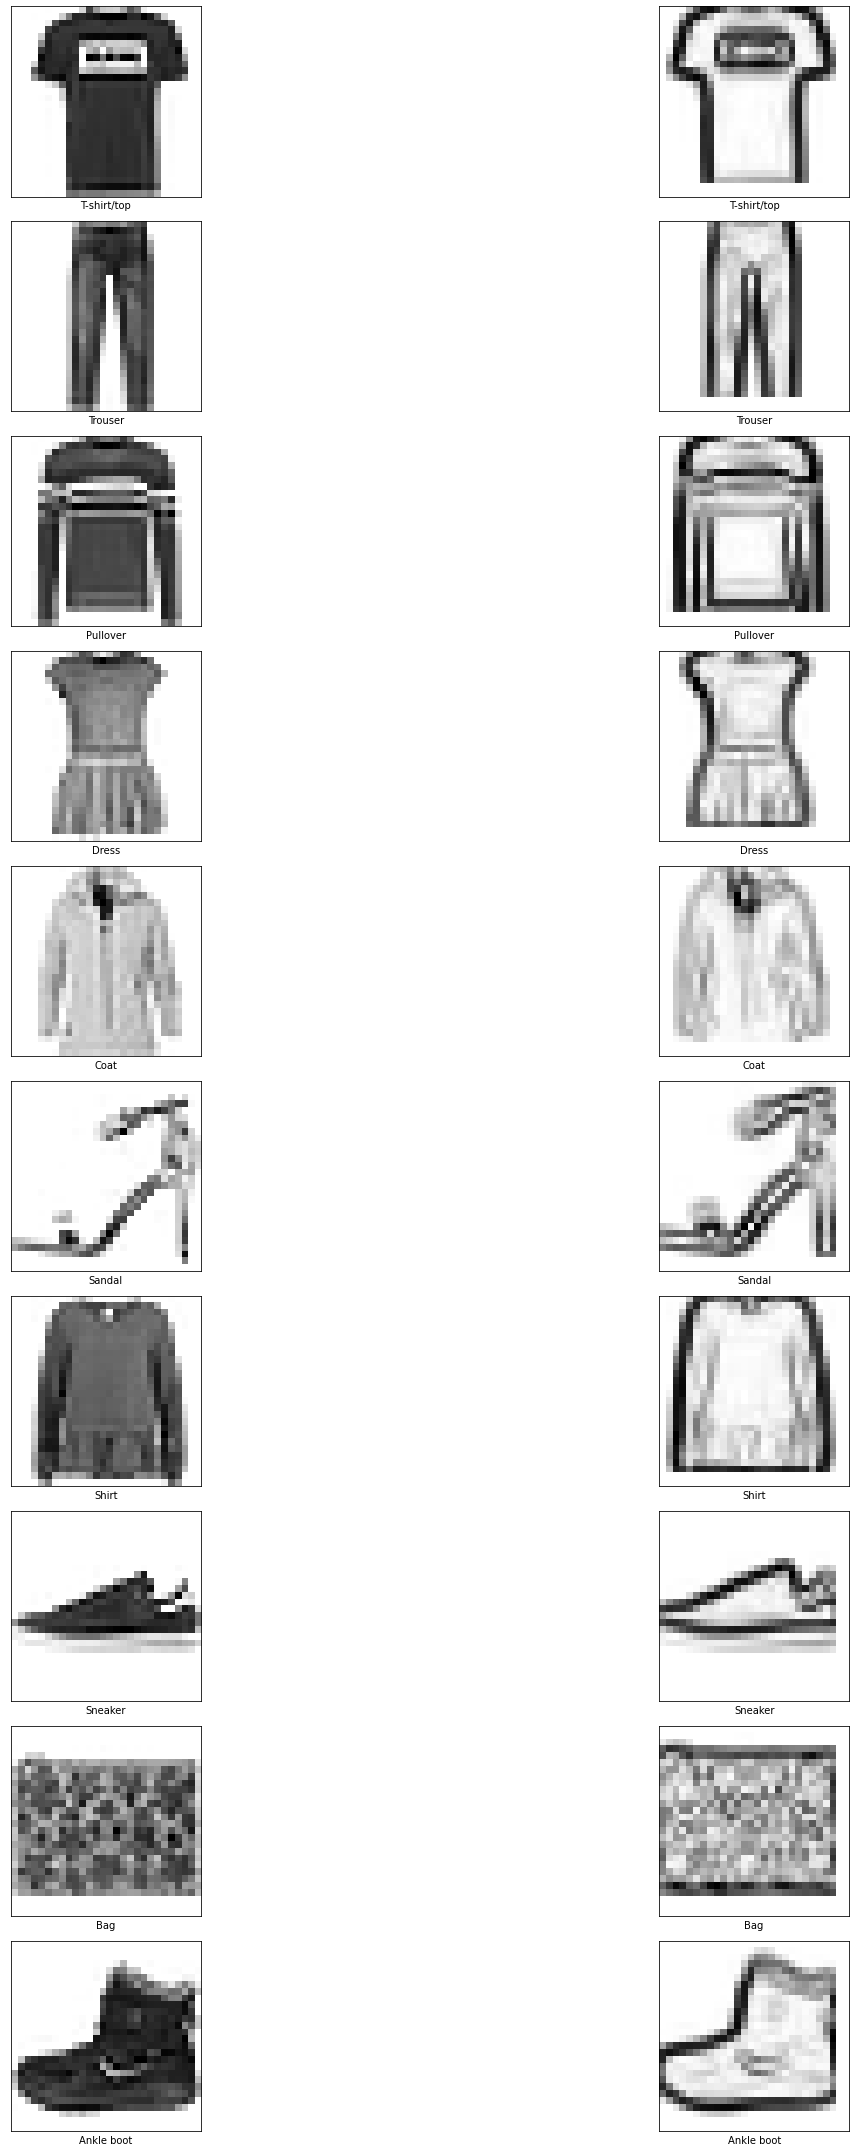

In [ ]:
classes = np.unique(train_labels)
plt.figure(figsize=(25,30))
index = 0
for c in classes:
    plt.subplot(10,2,index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = train_images[train_labels == c][0]
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[c])

    plt.subplot(10,2,index+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    fmap = convolve(image)    
    plt.imshow(fmap, cmap=plt.cm.binary)
    plt.xlabel(class_names[c])
    index += 2
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical

# scale pixels
def normalise(train, test):
  train_norm = train.astype('float32')
  test_norm = to_categorical(test)
  train_norm = train_norm / 255.0
  return train_norm, test_norm

In [ ]:
train_images_n, train_labels_n = normalise(train_images, train_labels)
test_images_n, test_labels_n = normalise(test_images, test_labels)

#### 2.5 Custom Entropy

In [ ]:
# Implement the loss (cross-entropy)
import tensorflow as tf
def cross_entropy_custom(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    output = y_pred / tf.reduce_sum(y_pred, -1, True)
    return -tf.reduce_sum(y_true * tf.math.log(output), -1)

#### 2.4 CNN model for classification

In [ ]:
# Model Structure 
import tensorflow as tf
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


def define_model(opt):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=opt, loss=cross_entropy_custom, metrics=['accuracy'])
    return model

In [ ]:
# # Test the model
histories = []
for opt in ['sgd', 'rmsprop', 'adam', 'adagrad']:
  # compile model
    model = define_model(opt)
    history = model.fit(train_images_n, train_labels_n, epochs=5, batch_size=512, verbose=1)
    histories.append(history)

Epoch 1/5
118/118 [==============================] - 12s 21ms/step - loss: 1.2368 - accuracy: 0.5567
Epoch 2/5
118/118 [==============================] - 2s 20ms/step - loss: 0.8100 - accuracy: 0.7128
Epoch 3/5
118/118 [==============================] - 2s 20ms/step - loss: 0.7103 - accuracy: 0.7445
Epoch 4/5
118/118 [==============================] - 2s 20ms/step - loss: 0.6466 - accuracy: 0.7679
Epoch 5/5
118/118 [==============================] - 2s 19ms/step - loss: 0.6074 - accuracy: 0.7817
Epoch 1/5
118/118 [==============================] - 4s 21ms/step - loss: 0.7494 - accuracy: 0.7311
Epoch 2/5
118/118 [==============================] - 2s 20ms/step - loss: 0.4544 - accuracy: 0.8349
Epoch 3/5
118/118 [==============================] - 2s 20ms/step - loss: 0.3970 - accuracy: 0.8567
Epoch 4/5
118/118 [==============================] - 2s 20ms/step - loss: 0.3629 - accuracy: 0.8682
Epoch 5/5
118/118 [==============================] - 2s 20ms/step - loss: 0.3376 - accuracy: 0.8778

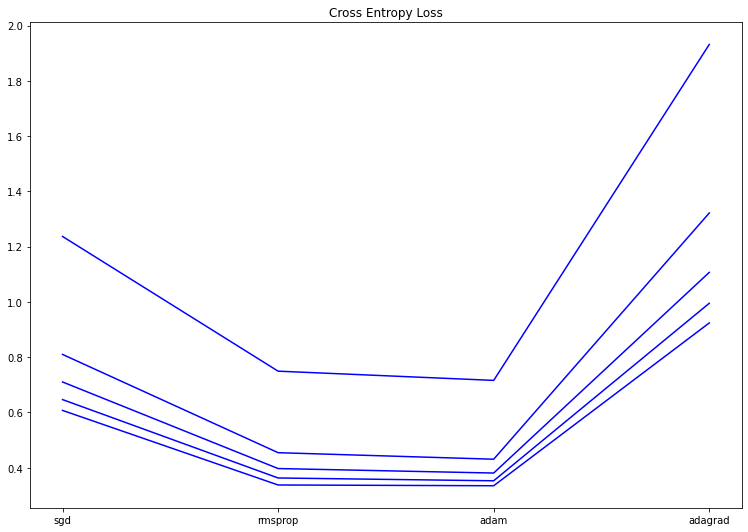

In [ ]:
X = ['sgd', 'rmsprop', 'adam', 'adagrad']
Y = []
for i in range(len(histories)):
    Y.append(histories[i].history['loss'])
plt.title('Cross Entropy Loss')
plt.plot(X, Y, color='blue', label='train')
plt.show()

### Comment

Cross entropy error correnponding to Root Mean Squared Propagation and adam are least compare to sgd and adagrad

In [ ]:
def custom_model(opt, number_of_layers, dropout_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    for _ in range(number_of_layers):
      model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
      model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### 1.6 different hyperparameters for Conv Layers

In [ ]:
# compile model
histories = []
DropRate = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# for hidden_layer in range(5):
hidden_layer = 1
for drop_rate in DropRate:
    model = custom_model('rmsprop', hidden_layer, drop_rate)
    history = model.fit(train_images_n, train_labels_n, epochs=5, batch_size=512, verbose=1)
    train_loss = history.history['loss'][0]
    train_acc = history.history['accuracy'][0]
    loss, acc = model.evaluate(test_images_n, test_labels_n, verbose=0)
    histories.append([train_loss, train_acc, loss, acc])

Epoch 1/5
118/118 [==============================] - 3s 20ms/step - loss: 0.6925 - accuracy: 0.7563
Epoch 2/5
118/118 [==============================] - 2s 20ms/step - loss: 0.4279 - accuracy: 0.8461
Epoch 3/5
118/118 [==============================] - 2s 20ms/step - loss: 0.3705 - accuracy: 0.8665
Epoch 4/5
118/118 [==============================] - 2s 20ms/step - loss: 0.3351 - accuracy: 0.8788
Epoch 5/5
118/118 [==============================] - 2s 20ms/step - loss: 0.3140 - accuracy: 0.8866
Epoch 1/5
118/118 [==============================] - 3s 22ms/step - loss: 0.7111 - accuracy: 0.7511
Epoch 2/5
118/118 [==============================] - 2s 21ms/step - loss: 0.4392 - accuracy: 0.8429
Epoch 3/5
118/118 [==============================] - 2s 21ms/step - loss: 0.3833 - accuracy: 0.8622
Epoch 4/5
118/118 [==============================] - 2s 21ms/step - loss: 0.3519 - accuracy: 0.8719
Epoch 5/5
118/118 [==============================] - 2s 21ms/step - loss: 0.3276 - accuracy: 0.8812


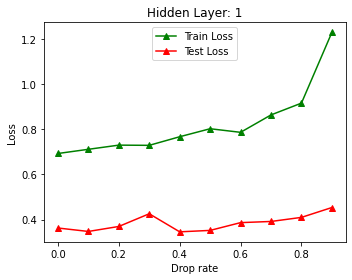

In [ ]:
histories = np.array(histories)
plt.figure(figsize=(5, 4))
plt.plot(DropRate, histories[:, 0], 'g^-', label="Train Loss")
plt.plot(DropRate, histories[:, 2], 'r^-', label="Test Loss")
plt.title("Hidden Layer: 1")
plt.xlabel("Drop rate")
plt.ylabel("Loss")
plt.rcParams["figure.figsize"] = [10.50, 7.50]
plt.rcParams["figure.autolayout"] = True
plt.legend(loc='upper center')
plt.show()

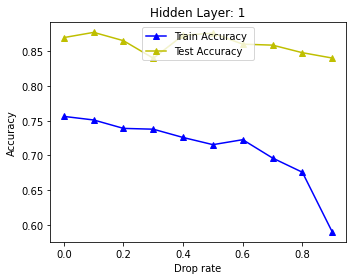

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(DropRate, histories[:, 1], 'b^-', label="Train Accuracy ")
plt.plot(DropRate, histories[:, 3], 'y^-', label="Test Accuracy ")
plt.title("Hidden Layer: 1")
plt.xlabel("Drop rate")
plt.ylabel("Accuracy")
plt.rcParams["figure.figsize"] = [10.50, 7.50]
plt.rcParams["figure.autolayout"] = True
plt.legend(loc='upper center')
plt.show()

In [ ]:
histories = []
drop_rate = 0.2
hidden_layer = [0, 1, 2]
for layer in hidden_layer:
        model = custom_model('rmsprop', layer, drop_rate)
        history = model.fit(train_images_n, train_labels_n, epochs=5, batch_size=512, verbose=1)
        train_loss = history.history['loss'][0]
        train_acc = history.history['accuracy'][0]
        loss, acc = model.evaluate(test_images_n, test_labels_n, verbose=0)
        histories.append([train_loss, train_acc, loss, acc])

Epoch 1/5
118/118 [==============================] - 2s 14ms/step - loss: 0.6958 - accuracy: 0.7598
Epoch 2/5
118/118 [==============================] - 2s 13ms/step - loss: 0.4280 - accuracy: 0.8461
Epoch 3/5
118/118 [==============================] - 2s 13ms/step - loss: 0.3646 - accuracy: 0.8706
Epoch 4/5
118/118 [==============================] - 2s 13ms/step - loss: 0.3307 - accuracy: 0.8827
Epoch 5/5
118/118 [==============================] - 2s 13ms/step - loss: 0.3084 - accuracy: 0.8904
Epoch 1/5
118/118 [==============================] - 3s 20ms/step - loss: 0.7128 - accuracy: 0.7475
Epoch 2/5
118/118 [==============================] - 3s 23ms/step - loss: 0.4382 - accuracy: 0.8430
Epoch 3/5
118/118 [==============================] - 3s 22ms/step - loss: 0.3827 - accuracy: 0.8632
Epoch 4/5
118/118 [==============================] - 2s 20ms/step - loss: 0.3528 - accuracy: 0.8734
Epoch 5/5
118/118 [==============================] - 2s 20ms/step - loss: 0.3281 - accuracy: 0.8824


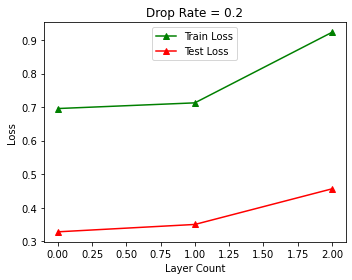

In [ ]:
histories = np.array(histories)
plt.figure(figsize=(5, 4))
plt.plot(hidden_layer, histories[:, 0], 'g^-', label="Train Loss")
plt.plot(hidden_layer, histories[:, 2], 'r^-', label="Test Loss")
plt.title("Drop Rate = 0.2")
plt.xlabel("Layer Count")
plt.ylabel("Loss")
plt.rcParams["figure.figsize"] = [10.50, 7.50]
plt.rcParams["figure.autolayout"] = True
plt.legend(loc='upper center')
plt.show()

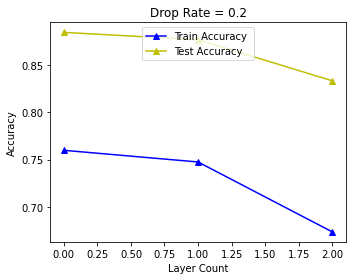

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(hidden_layer, histories[:, 1], 'b^-', label="Train Accuracy ")
plt.plot(hidden_layer, histories[:, 3], 'y^-', label="Test Accuracy ")
plt.title("Drop Rate = 0.2")
plt.xlabel("Layer Count")
plt.ylabel("Accuracy")
plt.rcParams["figure.figsize"] = [10.50, 7.50]
plt.rcParams["figure.autolayout"] = True
plt.legend(loc='upper center')
plt.show()

OBSERVATION:

1. Increasing the drop rate has incresed the training and test loss.

2. Increasing the drop rate has incresed the training accuracy but not the test accuracy.

